In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [17]:
import os, pickle, json, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# -----------------------------
# 0) 재현성 & Device
# -----------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 1) 경로/설정
# -----------------------------
DATA_CSV = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Real_Datasets/train_category_1.csv"        
PROCESSED_CSV = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/preprocess/processed.csv"
CKPT = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/checkepoint_box/checkpoints_best/vae_ctabgan_epoch150.pth"
TARGET_COL = "last_fico_range_high"                                      # 또는 "purpose", "home_ownership" 등
LATENT_DIM = 64                                           # 학습 당시 설정과 동일하게!

# -----------------------------
# 2) VAE Encoder 정의(당신 코드와 동일 인터페이스)
#    - mu, logvar 반환하도록.
# -----------------------------
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim = 64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        conv_out_dim = 64 * input_dim  # 입력을 (B, 1, input_dim)으로 받는다고 가정

        self.fc_mu = nn.Sequential(
            nn.Linear(conv_out_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.fc_logvar = nn.Sequential(
            nn.Linear(conv_out_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, input_dim)
        h = self.conv(x)
        h = self.flatten(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar

[kNN-Quartile(int_rate)] z=0.282/0.280 | rand=0.254/0.253 | xbase=0.295/0.293
[Silhouette(k=4)] z=0.043 | rand=0.008 | xbase=0.048
[Linear R2/MAE(int_rate)] z=0.089/42.910 | rand=-0.001/44.636 | xbase=0.086/43.027


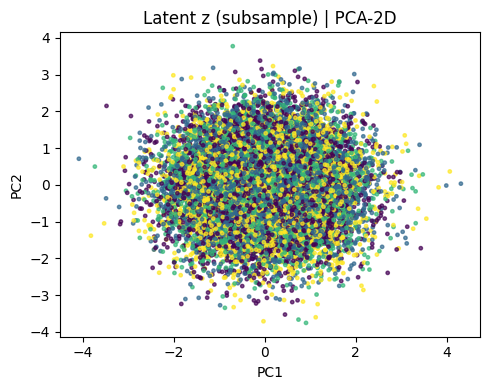

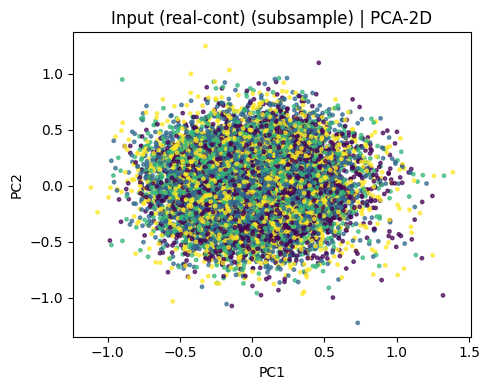

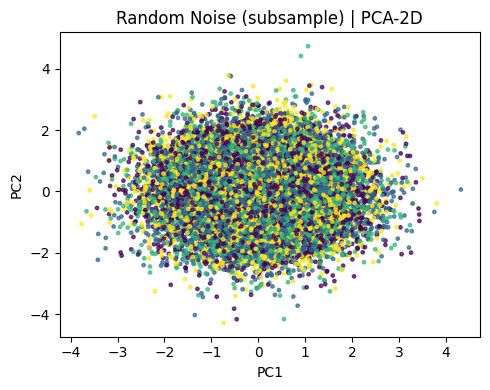

In [18]:
import os, pickle, json, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


import sys
sys.path.append("C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN")

# 1) 학습 당시와 동일한 transformer 로드
with open(r"C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/preprocess/transformer/transformer.pkl", "rb") as f:
    transformer = pickle.load(f)


with open(r"C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/preprocess/dataprep/dataprep.pkl", "rb") as f:
    prep = pickle.load(f)

# 2) 연속 성분(tanh) 인덱스 추출
cont_idx = []
offset = 0
for dim, act in transformer.output_info:  # 예: [(1,'tanh'), (7,'softmax'), (1,'tanh'), ...]
    if act == 'tanh':
        cont_idx.extend(range(offset, offset + dim))
    offset += dim

# 3) 전체 입력에서 연속 성분만 선택
X_full = pd.read_csv(PROCESSED_CSV).values.astype(np.float32)   # 210차원 등
X_cont = X_full[:, cont_idx].astype(np.float32)                 # => 14차원이어야 함

df = pd.read_csv(DATA_CSV)

# -----------------------------
# 4) Encoder 로드
# -----------------------------
input_dim = X_cont.shape[1]
encoder = VAEEncoder(input_dim=input_dim, latent_dim=LATENT_DIM).to(device)
ckpt = torch.load(CKPT, map_location=device)

# 키가 다를 수 있어서 방어적으로 처리
key_candidates = ["encoder_state_dict", "vae_encoder", "encoder", "state_dict", "model_state_dict"]
state = None
for k in key_candidates:
    if k in ckpt:
        state = ckpt[k]
        break
if state is None:
    # 전체 모델이 저장된 경우에서 encoder.*만 추출
    maybe = {k.replace("encoder.", ""): v for k, v in ckpt.items() if k.startswith("encoder.")}
    state = maybe if len(maybe) > 0 else ckpt

encoder.load_state_dict(state, strict=False)
encoder.eval()
for p in encoder.parameters(): p.requires_grad = False

# -----------------------------
# 5) z 추출 (mu 사용 권장: 안정적, 재현성 높음)
# -----------------------------
def get_mu_z(batch_np, batch_size=4096):
    zs = []
    with torch.no_grad():
        for i in range(0, len(batch_np), batch_size):
            xb = torch.from_numpy(batch_np[i:i+batch_size]).to(device)
            z, mu, logvar = encoder(xb)
            zs.append(mu.detach().cpu().numpy())
    return np.concatenate(zs, axis=0)

Z = get_mu_z(X_cont)

# 베이스라인 1: 랜덤 노이즈 (동일 분산/차원)
Z_rand = np.random.randn(*Z.shape).astype(np.float32)

# (선택) 베이스라인 2: 원 입력(변환공간) 자체
X_base = X_cont  # 동일 파이프라인으로 비교

# -----------------------------
# 6) k-NN probe (z만으로 속성 예측)
# -----------------------------
y_cont = prep.df["last_fico_range_high"].to_numpy().astype(np.float32)

qs = np.quantile(y_cont, [0, 0.25, 0.5, 0.75, 1.0])
y_bin = np.digitize(y_cont, qs[1:-1], right=True)  # 0~3 클래스

def knn_probe(feat, y_cls, k=7, test_size=0.3):
    Xtr, Xte, ytr, yte = train_test_split(feat, y_cls, test_size=test_size, random_state=SEED, stratify=y_cls)
    sc = StandardScaler().fit(Xtr)
    Xtr = sc.transform(Xtr); Xte = sc.transform(Xte)
    clf = KNeighborsClassifier(n_neighbors=k, weights="distance")
    clf.fit(Xtr, ytr)
    pred = clf.predict(Xte)
    acc = accuracy_score(yte, pred)
    f1 = f1_score(yte, pred, average="weighted")
    return acc, f1

acc_z, f1_z = knn_probe(Z, y_bin)
acc_r, f1_r = knn_probe(Z_rand, y_bin)
acc_x, f1_x = knn_probe(X_base, y_bin)
print(f"[kNN-Quartile(int_rate)] z={acc_z:.3f}/{f1_z:.3f} | rand={acc_r:.3f}/{f1_r:.3f} | xbase={acc_x:.3f}/{f1_x:.3f}")

# -----------------------------
# 7) Silhouette (라벨 없이 구조성 평가; 라벨 있을 경우 ARI도 가능)
#    - k는 도메인에 맞게: 예) loan_status=2 클래스면 2, grade면 7 등
# -----------------------------
from sklearn.cluster import KMeans
# 실루엣(클래스 수 = 4로 고정)
def silhouette_on(feat, n_clusters=4):
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=SEED)
    lab = km.fit_predict(feat)
    return silhouette_score(feat, lab)
sil_z = silhouette_on(Z, 4); sil_r = silhouette_on(Z_rand, 4); sil_x = silhouette_on(X_base, 4)
print(f"[Silhouette(k=4)] z={sil_z:.3f} | rand={sil_r:.3f} | xbase={sil_x:.3f}")

def linear_probe_r2_mae(feat, y, test_size=0.3):
    Xtr, Xte, ytr, yte = train_test_split(feat, y, test_size=test_size, random_state=SEED)
    sc = StandardScaler().fit(Xtr)
    Xtr = sc.transform(Xtr); Xte = sc.transform(Xte)
    reg = LinearRegression().fit(Xtr, ytr)
    pred = reg.predict(Xte)
    return r2_score(yte, pred), mean_absolute_error(yte, pred)

r2_z, mae_z   = linear_probe_r2_mae(Z, y_cont)
r2_r, mae_r   = linear_probe_r2_mae(Z_rand, y_cont)
r2_x, mae_x   = linear_probe_r2_mae(X_base, y_cont)
print(f"[Linear R2/MAE(int_rate)] z={r2_z:.3f}/{mae_z:.3f} | rand={r2_r:.3f}/{mae_r:.3f} | xbase={r2_x:.3f}/{mae_x:.3f}")


# -----------------------------
# 8) 시각화: PCA / t-SNE
# -----------------------------
idx = np.random.RandomState(42).choice(len(Z), size=min(20000, len(Z)), replace=False)

def plot_2d(feat, y_color, title):
    pca2 = PCA(n_components=2, random_state=SEED).fit_transform(feat)
    plt.figure(figsize=(5,4))
    plt.scatter(pca2[:,0], pca2[:,1], c=y_color, s=6, alpha=0.7)
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# 색상은 분류 타깃(y_bin)이나 연속값(y_cont) 중 택1
plot_2d(Z[idx],       y_bin[idx], "Latent z (subsample) | PCA-2D")
plot_2d(X_base[idx],  y_bin[idx], "Input (real-cont) (subsample) | PCA-2D")  # ← real
plot_2d(Z_rand[idx],  y_bin[idx], "Random Noise (subsample) | PCA-2D")

In [17]:
# expected in_features from ckpt
def expected_in_from_ckpt(state):
    w = state.get('fc_mu.0.weight', None)
    if w is None:
        # state가 중첩이면 꺼내세요 (예: encoder_state_dict)
        for k in ('encoder_state_dict','vae_encoder','state_dict','encoder'):
            if k in ckpt:
                w = ckpt[k]['fc_mu.0.weight']
                break
    return w.shape[1]

exp_in = expected_in_from_ckpt(state)
print("expected_in:", exp_in, "=> expected input_dim:", exp_in//64)
print("current X.shape[1]:", X.shape[1])


expected_in: 896 => expected input_dim: 14
current X.shape[1]: 222


In [18]:
import torch

ckpt_path = CKPT  # 네 checkpoint 경로
ckpt = torch.load(ckpt_path, map_location="cpu")

# 1) encoder state_dict 찾기
state = None
for k in ["encoder_state_dict", "vae_encoder", "encoder", "state_dict", "model_state_dict"]:
    if k in ckpt:
        state = ckpt[k]
        break
if state is None:
    # encoder.* prefix 제거
    maybe = {k.replace("encoder.", ""): v for k, v in ckpt.items() if k.startswith("encoder.")}
    state = maybe if len(maybe) > 0 else ckpt

# 2) fc_mu 첫 레이어의 weight shape 확인
if "fc_mu.0.weight" in state:
    in_features = state["fc_mu.0.weight"].shape[1]
    print(f"[Checkpoint] fc_mu.0.weight in_features = {in_features}")
    print(f"[Checkpoint] => expected input_dim = {in_features // 64}")
else:
    print("fc_mu.0.weight not found, keys:", list(state.keys())[:10])


[Checkpoint] fc_mu.0.weight in_features = 896
[Checkpoint] => expected input_dim = 14


In [6]:
import pickle
import numpy as np
import sys
sys.path.append("C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN")

# 1) 학습 당시와 동일한 transformer 로드
with open(r"C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/preprocess/transformer/transformer.pkl", "rb") as f:
    transformer = pickle.load(f)

# 2) 연속 성분(tanh) 인덱스 추출
cont_idx = []
offset = 0
for dim, act in transformer.output_info:  # 예: [(1,'tanh'), (7,'softmax'), (1,'tanh'), ...]
    if act == 'tanh':
        cont_idx.extend(range(offset, offset + dim))
    offset += dim

# 3) 전체 입력에서 연속 성분만 선택
X_full = pd.read_csv(PROCESSED_CSV).values.astype(np.float32)   # 210차원 등
X_cont = X_full[:, cont_idx].astype(np.float32)                 # => 14차원이어야 함
print("X_cont shape:", X_cont.shape)     

X_cont shape: (174231, 14)
